In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/ST/stargan

Mounted at /content/drive
/content/drive/MyDrive/ST/stargan


In [2]:
dataset = 'realworld_mobiact' # 'realworld' or 'cwru' or 'realworld_mobiact'

# Pre-trained Networks

## Domain Classifiers

In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import os

seed = 2710
np.random.seed(seed)
torch.manual_seed(seed)

class MultiBranchClassifier(nn.Module):
    def __init__(self, num_channels=3, num_domains=4, num_classes=5, num_timesteps=128):
        super(MultiBranchClassifier, self).__init__()
        # Shared layers for all branches
        self.conv1 = nn.Conv1d(num_channels, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.fc_shared = nn.Linear(num_timesteps * 8, 100)

        # Prepare class-specific branches as a single module with conditionally applied outputs
        self.fc_class_branches = nn.Linear(100, 50 * num_classes)
        self.fc_final = nn.Linear(50, num_domains)

    def forward(self, x, class_ids):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc_shared(x))

        # Process all class-specific branches simultaneously
        class_branches = self.fc_class_branches(x).view(x.size(0), -1, 50)
        class_outputs = class_branches[torch.arange(class_branches.size(0)), class_ids]

        # Final class-specific output
        final_outputs = self.fc_final(class_outputs.view(x.size(0), 50))
        return final_outputs.view(x.size(0), -1)


def split_data(x, y, k, test_size=0.2, random_state=seed):
    x_train, x_test, y_train, y_test, k_train, k_test = train_test_split(x, y, k,
                                                                         test_size=test_size,
                                                                         random_state=random_state,
                                                                         stratify=k,
                                                                         shuffle=True)
    return x_train, x_test, y_train, y_test, k_train, k_test


def setup_training(x_train, y_train, k_train, x_test, y_test, k_test, batch_size=64):
    # Convert numpy arrays to torch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    k_train_tensor = torch.tensor(k_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    k_test_tensor = torch.tensor(k_test, dtype=torch.long)

    # Create datasets and loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor, k_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor, k_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader


def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for x_batch, y_batch, k_batch in test_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            outputs = model(x_batch, y_batch)
            loss = F.cross_entropy(outputs, k_batch)
            total_loss += loss.item()

            # Assuming outputs are logits and k_batch are the true labels
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == k_batch).sum().item()
            total_predictions += k_batch.size(0)

    total_loss /= len(test_loader)
    accuracy = correct_predictions / total_predictions

    return total_loss, accuracy


def train_model(model, train_loader, test_loader, optimizer, epochs=300, name='domain_classifier'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_train = []
    loss_test = []
    accuracy_test = []
    best_loss = np.inf

    # Set up linear learning rate decay
    lambda_lr = lambda epoch: 1 - epoch / epochs
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, k_batch in train_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch, y_batch)
            loss = F.cross_entropy(outputs, k_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= len(train_loader)
        loss_train.append(total_loss)

        # Update learning rate
        scheduler.step()

        test_loss, test_accuracy = evaluate_model(model, test_loader, device=device)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict().copy()
        loss_test.append(test_loss)
        accuracy_test.append(test_accuracy)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch + 1}/{epochs} - Train loss: {total_loss:.4f} - Test loss: {test_loss:.4f} - Test accuracy: {test_accuracy:.4f} - LR: {current_lr:.6f}")

    # Save best model
    os.makedirs('pretrained_nets', exist_ok=True)
    if best_model is not None:
        print(f"Saving best model at epoch {np.argmin(loss_test) + 1} and test loss {best_loss:.4f}")
        torch.save(best_model, f"pretrained_nets/{name}.ckpt")
    else:
        print("No best model found, saving current model")
        torch.save(model.state_dict(), f"pretrained_nets/{name}.ckpt")

    return loss_train, loss_test, accuracy_test

(11783, 3, 128) (11783,) (11783,)
(9426, 3, 128) (2357, 3, 128) (9426,) (2357,) (9426,) (2357,)
Epoch 1/300 - Train loss: 2.5010 - Test loss: 2.0967 - Test accuracy: 0.3314 - LR: 0.000100
Epoch 2/300 - Train loss: 1.7214 - Test loss: 1.3740 - Test accuracy: 0.6042 - LR: 0.000099
Epoch 3/300 - Train loss: 1.1701 - Test loss: 0.9752 - Test accuracy: 0.7488 - LR: 0.000099
Epoch 4/300 - Train loss: 0.8417 - Test loss: 0.7236 - Test accuracy: 0.8091 - LR: 0.000099
Epoch 5/300 - Train loss: 0.6044 - Test loss: 0.5221 - Test accuracy: 0.8621 - LR: 0.000098
Epoch 6/300 - Train loss: 0.4635 - Test loss: 0.4172 - Test accuracy: 0.8838 - LR: 0.000098
Epoch 7/300 - Train loss: 0.3687 - Test loss: 0.3330 - Test accuracy: 0.9007 - LR: 0.000098
Epoch 8/300 - Train loss: 0.3030 - Test loss: 0.2965 - Test accuracy: 0.9134 - LR: 0.000097
Epoch 9/300 - Train loss: 0.2549 - Test loss: 0.2663 - Test accuracy: 0.9262 - LR: 0.000097
Epoch 10/300 - Train loss: 0.2201 - Test loss: 0.2407 - Test accuracy: 0.930

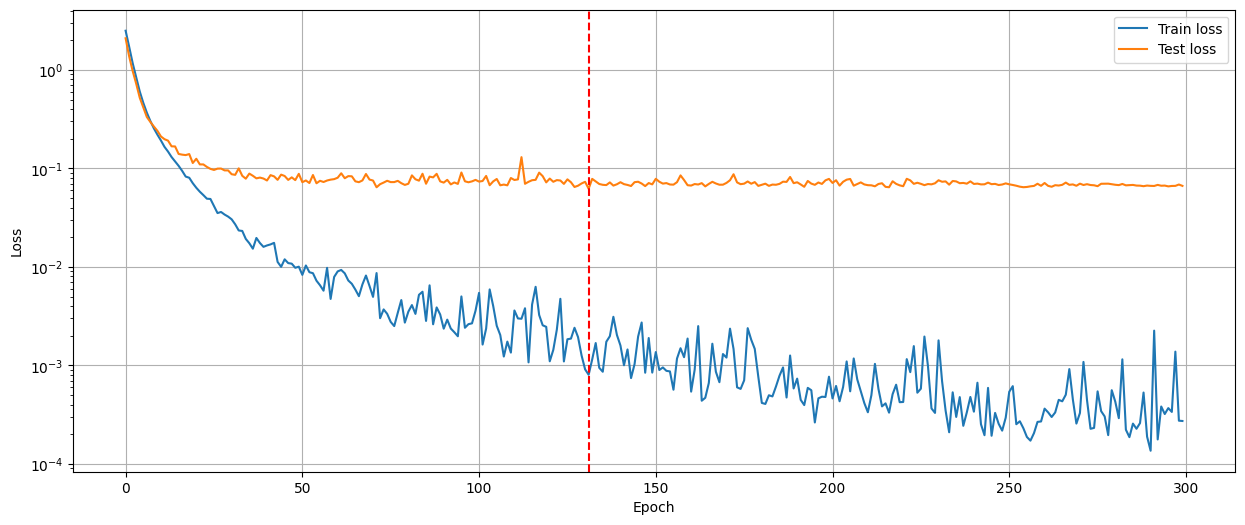

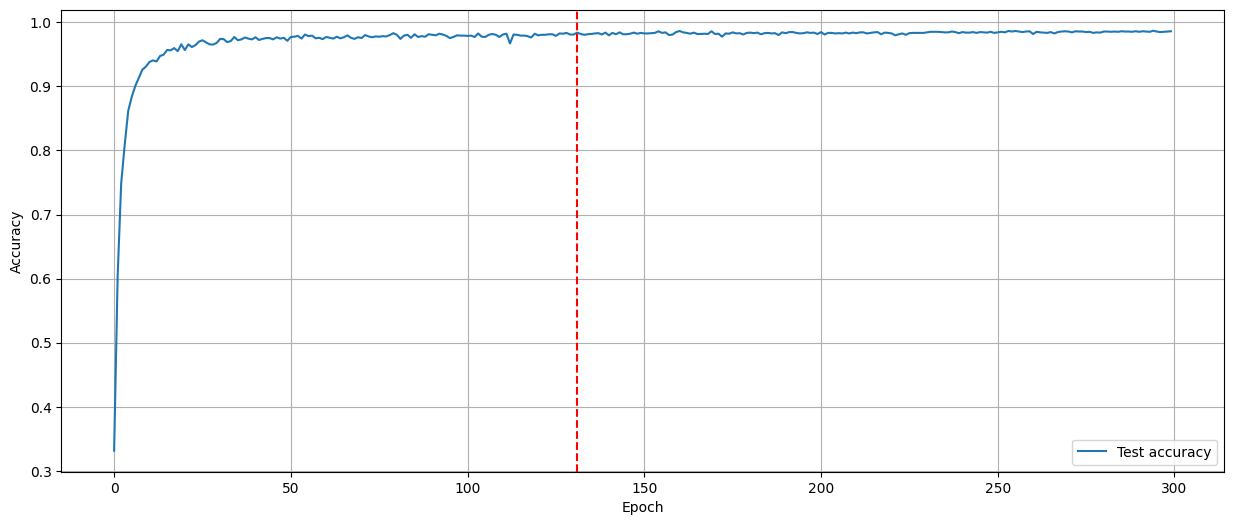

In [4]:
# Train domain classifier on Df

if dataset == 'realworld':
    dataset_name = 'realworld'
    num_df_domains = 10
    num_dp_domains = 5
    num_classes = 4

elif dataset == 'cwru':
    dataset_name = 'cwru_256_3ch_5cl'
    num_df_domains = 4
    num_dp_domains = 4
    num_classes = 5

elif dataset == 'realworld_mobiact':
    dataset_name = 'realworld_mobiact'
    num_df_domains = 15
    num_dp_domains = 61
    num_classes = 4


with open(f'data/{dataset_name}.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

x = x[k < num_df_domains]
y = y[k < num_df_domains]
k = k[k < num_df_domains]
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchClassifier(num_domains=num_df_domains, num_classes=num_classes, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, accuracy_test = train_model(model, train_loader, test_loader, optimizer, epochs=300, name=f'domain_classifier_{dataset}_df')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Test accuracy: {accuracy_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the test accuracy
plt.figure(figsize=(15, 6))
plt.plot(accuracy_test, label='Test accuracy')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Train domain classifier on Dp

with open(f'data/{dataset_name}.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

with open(f'data/{dataset_name}_fs.pkl', 'rb') as f:
    fs = pickle.load(f)

x = x[fs == 0]
y = y[fs == 0]
k = k[fs == 0]
x = x[k >= num_df_domains]
y = y[k >= num_df_domains]
k = k[k >= num_df_domains] - num_df_domains
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchClassifier(num_domains=num_dp_domains, num_classes=num_classes, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = nn.CrossEntropyLoss()

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, accuracy_test = train_model(model, train_loader, test_loader, optimizer, epochs=300, name=f'domain_classifier_{dataset}_dp')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Test accuracy: {accuracy_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the test accuracy
plt.figure(figsize=(15, 6))
plt.plot(accuracy_test, label='Test accuracy')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

(9596, 3, 128) (9596,) (9596,)
(7676, 3, 128) (1920, 3, 128) (7676,) (1920,) (7676,) (1920,)
Epoch 1/300 - Train loss: 4.0087 - Test loss: 3.8020 - Test accuracy: 0.0604 - LR: 0.000100
Epoch 2/300 - Train loss: 3.5478 - Test loss: 3.2703 - Test accuracy: 0.1807 - LR: 0.000099
Epoch 3/300 - Train loss: 3.0004 - Test loss: 2.7233 - Test accuracy: 0.3224 - LR: 0.000099
Epoch 4/300 - Train loss: 2.4456 - Test loss: 2.1912 - Test accuracy: 0.5068 - LR: 0.000099
Epoch 5/300 - Train loss: 1.9590 - Test loss: 1.7656 - Test accuracy: 0.6323 - LR: 0.000098
Epoch 6/300 - Train loss: 1.5955 - Test loss: 1.4647 - Test accuracy: 0.7021 - LR: 0.000098
Epoch 7/300 - Train loss: 1.3328 - Test loss: 1.2330 - Test accuracy: 0.7495 - LR: 0.000098
Epoch 8/300 - Train loss: 1.1406 - Test loss: 1.0928 - Test accuracy: 0.7688 - LR: 0.000097
Epoch 9/300 - Train loss: 0.9866 - Test loss: 0.9679 - Test accuracy: 0.7958 - LR: 0.000097
Epoch 10/300 - Train loss: 0.8807 - Test loss: 0.8832 - Test accuracy: 0.8141 -

## Siamese Networks

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import os

seed = 2710
np.random.seed(seed)
torch.manual_seed(seed)

class MultiBranchSiameseNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=5, num_timesteps=128):
        super(MultiBranchSiameseNet, self).__init__()
        # Shared layers
        self.conv1 = nn.Conv1d(num_channels, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.fc_shared = nn.Linear(num_timesteps * 8, 100)

        # Class-specific branches
        self.fc_class_branches = nn.Linear(100, 50 * num_classes)

    def forward_once(self, x, class_id):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc_shared(x))
        print(x.size())

        # Process class-specific branch
        class_branches = self.fc_class_branches(x).view(x.size(0), -1, 50)
        print(class_branches.size())
        class_output = class_branches[torch.arange(class_branches.size(0)), class_id]
        print(class_output.size())
        return class_output


def split_data(x, y, k, test_size=0.2, random_state=seed):
    x_train, x_test, y_train, y_test, k_train, k_test = train_test_split(x, y, k,
                                                                         test_size=test_size,
                                                                         random_state=random_state,
                                                                         stratify=k,
                                                                         shuffle=True)
    return x_train, x_test, y_train, y_test, k_train, k_test


def setup_training(x_train, y_train, k_train, x_test, y_test, k_test, batch_size=64):
    # Convert numpy arrays to torch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    k_train_tensor = torch.tensor(k_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    k_test_tensor = torch.tensor(k_test, dtype=torch.long)

    # Create datasets and loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor, k_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor, k_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader


def evaluate_model(model, test_loader, device='cpu', margin=1.0):
    model.eval()
    total_loss = 0
    same_domain_distance = 0
    diff_domain_distance = 0
    same_domain_count = 0
    diff_domain_count = 0

    with torch.no_grad():
        for x_batch, y_batch, k_batch in test_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            batch_size = x_batch.size(0)

            # Compute all pairwise outputs
            output1 = model.forward_once(x_batch.unsqueeze(1).expand(-1, batch_size, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(1).expand(-1, batch_size).reshape(-1))
            output2 = model.forward_once(x_batch.unsqueeze(0).expand(batch_size, -1, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(0).expand(batch_size, -1).reshape(-1))

            output1 = output1.view(batch_size, batch_size, -1)
            output2 = output2.view(batch_size, batch_size, -1)

            # Compute pairwise distances
            euclidean_distances = F.pairwise_distance(output1, output2, keepdim=True).view(batch_size, batch_size)

            # Compute pairwise labels
            labels = (k_batch.unsqueeze(1) != k_batch.unsqueeze(0)).float()

            # Compute loss
            loss = (1 - labels) * torch.pow(euclidean_distances, 2) + labels * torch.pow(torch.clamp(margin - euclidean_distances, min=0.0), 2)
            total_loss += loss.mean().item()

            # Compute distances for same and different domains
            same_domain_distance += euclidean_distances[labels == 0].sum().item()
            diff_domain_distance += euclidean_distances[labels == 1].sum().item()
            same_domain_count += (labels == 0).sum().item()
            diff_domain_count += (labels == 1).sum().item()

    total_loss /= len(test_loader)
    avg_same_domain_distance = same_domain_distance / same_domain_count if same_domain_count > 0 else 0
    avg_diff_domain_distance = diff_domain_distance / diff_domain_count if diff_domain_count > 0 else 0

    return total_loss, avg_same_domain_distance, avg_diff_domain_distance


def train_model(model, train_loader, test_loader, optimizer, epochs=300, name='siamese_net', margin=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_train = []
    loss_test = []
    avg_same_domain_distance_test = []
    avg_diff_domain_distance_test = []
    best_loss = np.inf

    # Set up linear learning rate decay
    lambda_lr = lambda epoch: 1 - epoch / epochs
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, k_batch in train_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            batch_size = x_batch.size(0)

            # Compute all pairwise outputs
            output1 = model.forward_once(x_batch.unsqueeze(1).expand(-1, batch_size, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(1).expand(-1, batch_size).reshape(-1))
            output2 = model.forward_once(x_batch.unsqueeze(0).expand(batch_size, -1, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(0).expand(batch_size, -1).reshape(-1))

            output1 = output1.view(batch_size, batch_size, -1)
            output2 = output2.view(batch_size, batch_size, -1)

            # Compute pairwise distances
            euclidean_distances = F.pairwise_distance(output1, output2, keepdim=True).view(batch_size, batch_size)

            # Compute pairwise labels
            labels = (k_batch.unsqueeze(1) != k_batch.unsqueeze(0)).float()

            # Compute loss
            loss = (1 - labels) * torch.pow(euclidean_distances, 2) + labels * torch.pow(torch.clamp(margin - euclidean_distances, min=0.0), 2)
            total_loss += loss.mean().item()

            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

        total_loss /= len(train_loader)
        loss_train.append(total_loss)

        # Update learning rate
        scheduler.step()

        test_loss, avg_same_domain_distance, avg_diff_domain_distance = evaluate_model(model, test_loader, device=device)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict().copy()
        loss_test.append(test_loss)
        avg_same_domain_distance_test.append(avg_same_domain_distance)
        avg_diff_domain_distance_test.append(avg_diff_domain_distance)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch + 1}/{epochs} - Train loss: {total_loss:.4f} - Test loss: {test_loss:.4f} - "
              f"Avg same domain distance: {avg_same_domain_distance:.4f} - Avg diff domain distance: {avg_diff_domain_distance:.4f} - LR: {current_lr:.6f}")

    # Save best model
    os.makedirs('pretrained_nets', exist_ok=True)
    if best_model is not None:
        print(f"Saving best model at epoch {np.argmin(loss_test) + 1} and test loss {best_loss:.4f}")
        torch.save(best_model, f"pretrained_nets/{name}.ckpt")
    else:
        print("No best model found, saving current model")
        torch.save(model.state_dict(), f"pretrained_nets/{name}.ckpt")

    return loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test

In [ ]:
# Train Siamese network on Df

if dataset == 'realworld':
    dataset_name = 'realworld'
    num_df_domains = 10
    num_dp_domains = 5
    num_classes = 4

elif dataset == 'cwru':
    dataset_name = 'cwru_256_3ch_5cl'
    num_df_domains = 4
    num_dp_domains = 4
    num_classes = 5

elif dataset == 'realworld_mobiact':
    dataset_name = 'realworld_mobiact'
    num_df_domains = 15
    num_dp_domains = 61
    num_classes = 4


with open(f'data/{dataset_name}.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

x = x[k < num_df_domains]
y = y[k < num_df_domains]
k = k[k < num_df_domains]
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchSiameseNet(num_classes=num_classes, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test = train_model(model, train_loader, test_loader, optimizer, epochs=200, name=f'siamese_net_{dataset}_df')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Avg same domain distance: {avg_same_domain_distance_test[best_epoch]:.4f} - Avg diff domain distance: {avg_diff_domain_distance_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the average same domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_same_domain_distance_test, label='Avg same domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Same Domain Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the average different domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_diff_domain_distance_test, label='Avg diff domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Diff Domain Distance')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Train Siamese Network on Dp

with open(f'data/{dataset_name}.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

with open(f'data/{dataset_name}_fs.pkl', 'rb') as f:
    fs = pickle.load(f)

x = x[fs == 0]
y = y[fs == 0]
k = k[fs == 0]
x = x[k >= num_df_domains]
y = y[k >= num_df_domains]
k = k[k >= num_df_domains] - num_df_domains
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchSiameseNet(num_classes=num_classes, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test = train_model(model, train_loader, test_loader, optimizer, epochs=200, name=f'siamese_net_{dataset}_dp')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Avg same domain distance: {avg_same_domain_distance_test[best_epoch]:.4f} - Avg diff domain distance: {avg_diff_domain_distance_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the average same domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_same_domain_distance_test, label='Avg same domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Same Domain Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the average different domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_diff_domain_distance_test, label='Avg diff domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Diff Domain Distance')
plt.legend()
plt.grid()
plt.show()